a, b と改行で並べるだけで出力できるように設定します

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

`data/input/train.csv` のデータを元に主要な統計量を計算します。

In [2]:
from numpy import test
import pandas as pd
import sys
from pathlib import Path
# codeフォルダへのパスを追加
sys.path.append(str(Path("..").resolve()))
from python.path_utils import input_path

# パス設定
INPUT_PATH = input_path("train.csv")
TEST_PATH = input_path("test.csv")

# データ読み込み
df = pd.read_csv(INPUT_PATH)
test_df = pd.read_csv(TEST_PATH)

dfの内容を詳しく見ます。

In [14]:
# 構造の把握
df
df.shape          # (行数, 列数)
df.dtypes         # 各列の型
df.info()         # 型 + 非null数 + メモリ使用量を一覧表示
df.describe()     # 数値列の統計量（count, mean, std, min, max, 四分位）

# データの中身を見る
df.head()         # 先頭5行（引数で行数指定可）
df.tail(10)       # 末尾10行
df.sample(5)      # ランダムに5行（偏りなく雰囲気を掴める）

# 欠損・ユニーク値
df.isnull().sum()          # 列ごとの欠損数
df["Age"].value_counts()   # カテゴリ列の分布
df.nunique()               # 列ごとのユニーク値数

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


(891, 12)

PassengerId       int64
Survived          int64
Pclass            int64
Name                str
Sex                 str
Age             float64
SibSp             int64
Parch             int64
Ticket              str
Fare            float64
Cabin               str
Embarked       category
dtype: object

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    str     
 4   Sex          891 non-null    str     
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    str     
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    str     
 11  Embarked     891 non-null    category
dtypes: category(1), float64(2), int64(5), str(4)
memory usage: 77.7 KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
881,882,0,3,"Markun, Mr. Johann",male,33.000000,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.000000,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.000000,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.000000,0,0,370376,7.7500,NaN,Q


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
685,686,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S
352,353,0,3,"Elias, Mr. Tannous",male,15.0,1,1,2695,7.2292,NaN,C


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Age
29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
24.500000      1
0.670000       1
0.420000       1
34.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             89
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Age・cabin・embarked列には欠損値があることがわかります。
それらのカラムのデータ型を確認しましょう。

In [5]:
df.dtypes[df.isnull().sum() > 0]

Age         float64
Cabin           str
Embarked        str
dtype: object

Ageは数値列、cabinとembarkedは文字列列であることがわかります。
Age列は数値が入っているため、平均や中央値などの統計量を計算できます。

In [6]:
df.nunique()[df.isnull().sum() > 0]

Age          88
Cabin       147
Embarked      3
dtype: int64

文字列型のCabinとEmbarkedですが、Embarkedはユニークな値が3つしかないため、カテゴリ列として扱うことができます。
ひとまず、最も多い値で欠損値を埋めることにしましょう。

In [7]:
df["Embarked"].unique()

<StringArray>
['S', 'C', 'Q', nan]
Length: 4, dtype: str

In [8]:
# Embarkedの最頻値で欠損を補完しカテゴリ型に変換
embarked_mode = df["Embarked"].mode(dropna=True)[0]
# 欠損値を最頻値で埋めてからカテゴリ型に変換
# カテゴリ型に変換することで、モデルが文字列を数値として扱えるようになります。（ENUM型のようなもの）
df["Embarked"] = df["Embarked"].fillna(embarked_mode).astype("category")

# 確認
embarked_mode
df["Embarked"].isnull().sum()
df["Embarked"].value_counts()

'S'

np.int64(0)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [9]:
# Ageの平均値で欠損を補完
age_mean = df["Age"].mean()
df["Age"] = df["Age"].fillna(age_mean)

# 確認
age_mean
df["Age"].isnull().sum()
df["Age"].describe()

np.float64(29.69911764705882)

np.int64(0)

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

Cabin列はユニークな値も多く、欠損値も多いため、今回は削除してしまいましょう。

In [ ]:
# Cabin列を削除
df = df.drop(columns=["Cabin"] )

# 確認
"Cabin" in df.columns, df.shape

In [15]:
from sklearn.tree import DecisionTreeClassifier

# 元データからモデルをトレーニング
y = df["Survived"]
features = ["Age", "Embarked"]

# EmbarkedはすでにCategory型なので、cat.codesで整数に変換する
# get_dummies（ワンホットエンコーディング）だと Embarked_C <= 0.5 のような
# 「実質 == 0 か？」という読みにくい条件が生まれてしまうため
X = df[features].copy()
X["Embarked"] = X["Embarked"].cat.codes  # C=0, Q=1, S=2 のような整数に変換

# criterionにはgini（ジニ不純度）とentropy（エントロピー）があります。どちらも大きな差はないことが多いため、今回はginiを使用します。
model = DecisionTreeClassifier(max_depth=3, criterion='gini', min_samples_leaf=5, random_state=42)
model.fit(X, y)

print(f"Train: {model.score(X, y):.3f}")
print(f"\nEmbarkedのコード対応: {dict(enumerate(df['Embarked'].cat.categories))}")


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

Train: 0.652

Embarkedのコード対応: {0: 'C', 1: 'Q', 2: 'S'}


<Figure size 1600x800 with 0 Axes>

[Text(0.4230769230769231, 0.875, 'Embarked <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Not Survived'),
 Text(0.15384615384615385, 0.625, 'Age <= 7.0\ngini = 0.494\nsamples = 168\nvalue = [75, 93]\nclass = Survived'),
 Text(0.28846153846153844, 0.75, 'True  '),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = Survived'),
 Text(0.23076923076923078, 0.375, 'Age <= 26.5\ngini = 0.498\nsamples = 160\nvalue = [75, 85]\nclass = Survived'),
 Text(0.15384615384615385, 0.125, 'gini = 0.465\nsamples = 49\nvalue = [18, 31]\nclass = Survived'),
 Text(0.3076923076923077, 0.125, 'gini = 0.5\nsamples = 111\nvalue = [57, 54]\nclass = Not Survived'),
 Text(0.6923076923076923, 0.625, 'Age <= 6.5\ngini = 0.452\nsamples = 723\nvalue = [474, 249]\nclass = Not Survived'),
 Text(0.5576923076923077, 0.75, '  False'),
 Text(0.5384615384615384, 0.375, 'Age <= 2.5\ngini = 0.46\nsamples = 39\nvalue = [14.0, 25.0]\nclass = Survived'),
 Text(0.46153846153846156

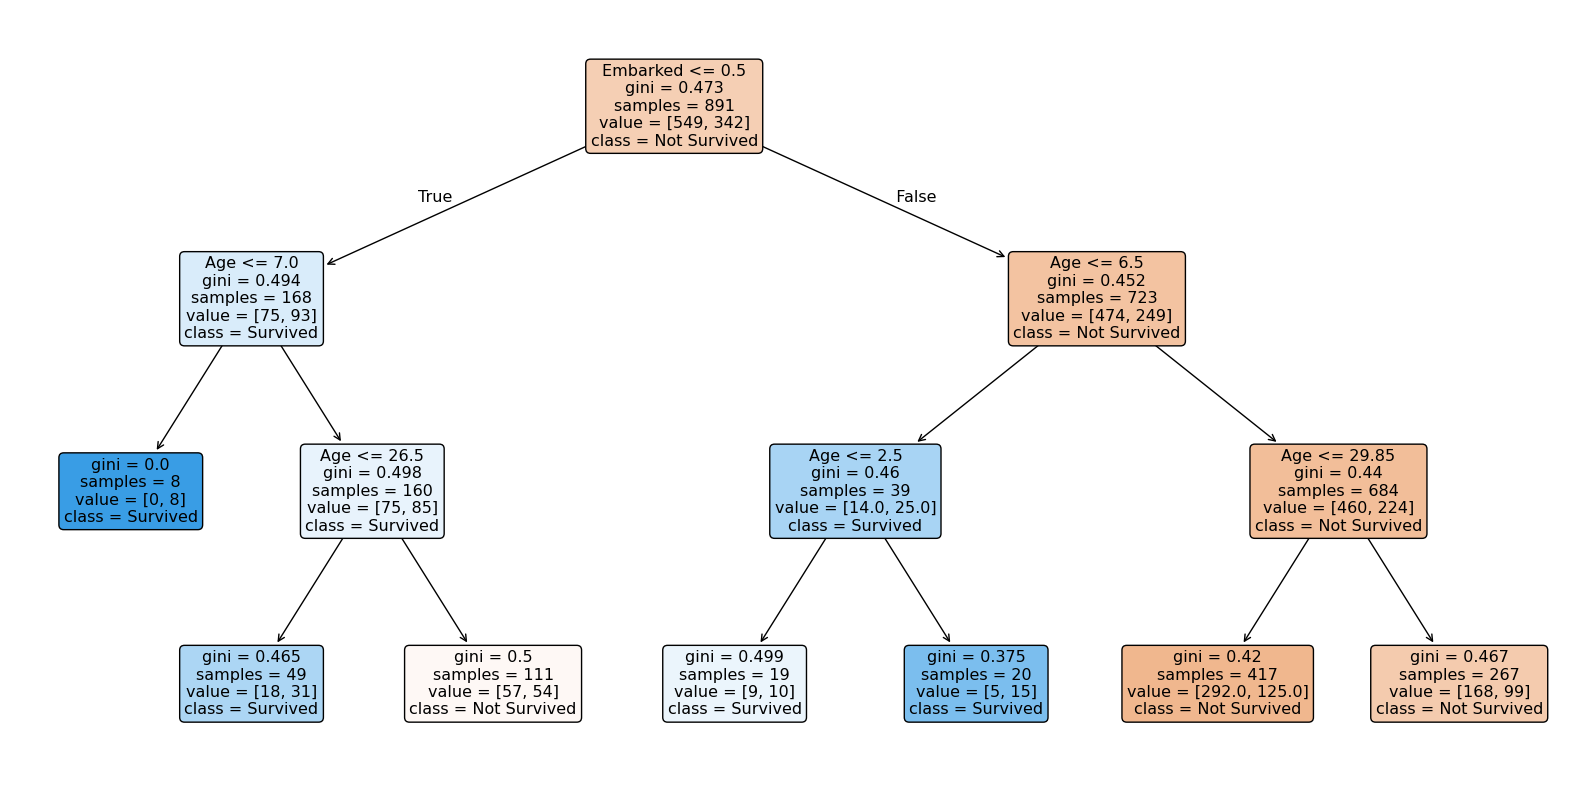

In [16]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 8))
plot_tree(model, feature_names=X.columns,
          class_names=["Not Survived", "Survived"], filled=True, rounded=True)
plt.tight_layout()
plt.savefig("tree.png", dpi=150)
plt.show()